In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
# mpl.use('Cairo')  # for saving SVGs that Affinity Designer can parse
import matplotlib.pyplot as plt
import seaborn as sns
import dill

import candas as can
import pathlib as pl

code_pth = pl.Path.cwd()  # for running in Jupyter
# code_pth = pl.Path(__file__)  # for running in terminal
fig_pth = code_pth.parent
data_pth = fig_pth / 'data'
graph_pth = fig_pth / 'graphics'
graph_pth.mkdir(exist_ok=True)

gen_pth = fig_pth / 'generated'
gen_pth.mkdir(exist_ok=True)

plt.style.use(str(can.style.breve))

%config InlineBackend.figure_format = 'retina'

In [2]:
from utils import savefig

plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["lines.linewidth"] = 2

In [3]:
width = 3.45
height = 2.75 + 0.2
figsize = (width, height)
spotsize = 4**2
ticklabelsize = 5
labelsize = 6
linewidth = 1

palette = sns.diverging_palette(20, 220, as_cmap=True)

mar_l = 0.3
mar_r = 0.3
mar_t = 0.22
mar_b = 0.275 + 0.2
ax_space = 0.075


def format_sns_axes(fig, axs, axes_dict, xticks, xlim, ylim=None, width=width, height=height, mar_b=mar_b, mar_l=mar_l, mar_r=mar_r, mar_t=mar_t, ax_space=ax_space):
    fig.set_size_inches((width, height))

    ylim = ylim or [-1.1, 1.1]

    plt.setp(
        axs,
        ylim=ylim,
        yticks=[-1, -0.5, 0, 0.5, 1],
        xticks=xticks,
        xlim=xlim,
        title="",
    )
    for i, ax in enumerate(axs.flat):
        ax.tick_params(axis="both", labelsize=ticklabelsize, length=1, width=0.6)
        ax.set_ylabel(ax.get_ylabel(), fontsize=labelsize, labelpad=0)
        ax.set_xlabel(ax.get_xlabel(), fontsize=labelsize, labelpad=2)
        # if i > 0:
        #     ax.yaxis.set_tick_params(length=0)
        ax.axhline(0, color="k", linestyle="-", linewidth=0.5, zorder=-1)

    for (row, col), ax in axes_dict.items():
        ax.set_title("")

        if col == 8.0:
            ax2 = ax.twinx()
            ax2.set_yticks([])
            ax2.set_ylabel(
                f"{row:.1f}", va="bottom", fontsize=labelsize, rotation=270, labelpad=1
            )
            if row == 5.0:
                ax2.set_ylabel(
                    f"log$_{1}$$_{0}$ Copies Competitor 2\n{row:.1f}",
                    va="bottom",
                    fontsize=labelsize,
                    rotation=270,
                    labelpad=1,
                )

        if row == 8.0:
            ax.set_title(f"{col:.1f}", fontsize=labelsize, pad=2)
            if col == 5.0:
                ax.set_title(
                    f"log$_{1}$$_{0}$ Copies Competitor 1\n{col:.1f}",
                    fontsize=labelsize,
                    pad=2,
                )

        if ax != axs[-1, 0]:
            ax.set_xlabel("")
            ax.set_ylabel("")

    bbox = ax.get_window_extent().transformed(ax.figure.dpi_scale_trans.inverted())
    ax_width, ax_height = bbox.width, bbox.height

    plt.subplots_adjust(
        left=mar_l / width,
        right=1 - mar_r / width,
        top=1 - mar_t / height,
        bottom=mar_b / height,
        wspace=ax_space / ax_width,
        hspace=ax_space / ax_height,
    )

In [4]:
ps = pd.read_pickle(data_pth / "ADVI_ParameterSets.pkl")
ps = pd.read_pickle(data_pth / "ADVI_ParameterSets_220528.pkl")
ps = ps[ps.Metric == 'mean']

In [5]:
def get_lg10_Q_fun(data):
    K = data.groupby("lg10_Copies")["K"].mean()
    F0_lg = data.groupby("lg10_Copies")["F0_lg"].mean()
    lg_Q = (
        (F0_lg - np.log10(K) - (7 + 5 - np.log10(6.022e23)))
        .rename("mean")
        .reset_index()
    )
    lg_Q_fun = np.poly1d(np.polyfit(lg_Q.lg10_Copies, lg_Q["mean"], 1))
    return lg_Q_fun

import jax.numpy as jnp

wt_rate=0.708 | ref1_rate=0.644 | ref2_rate=0.650
Saving fig_S9A__stretchy_tetra in /home/john/projects/can-manuscript/fig_S9__soft_lamprey/graphics: [.svg] [.png] done


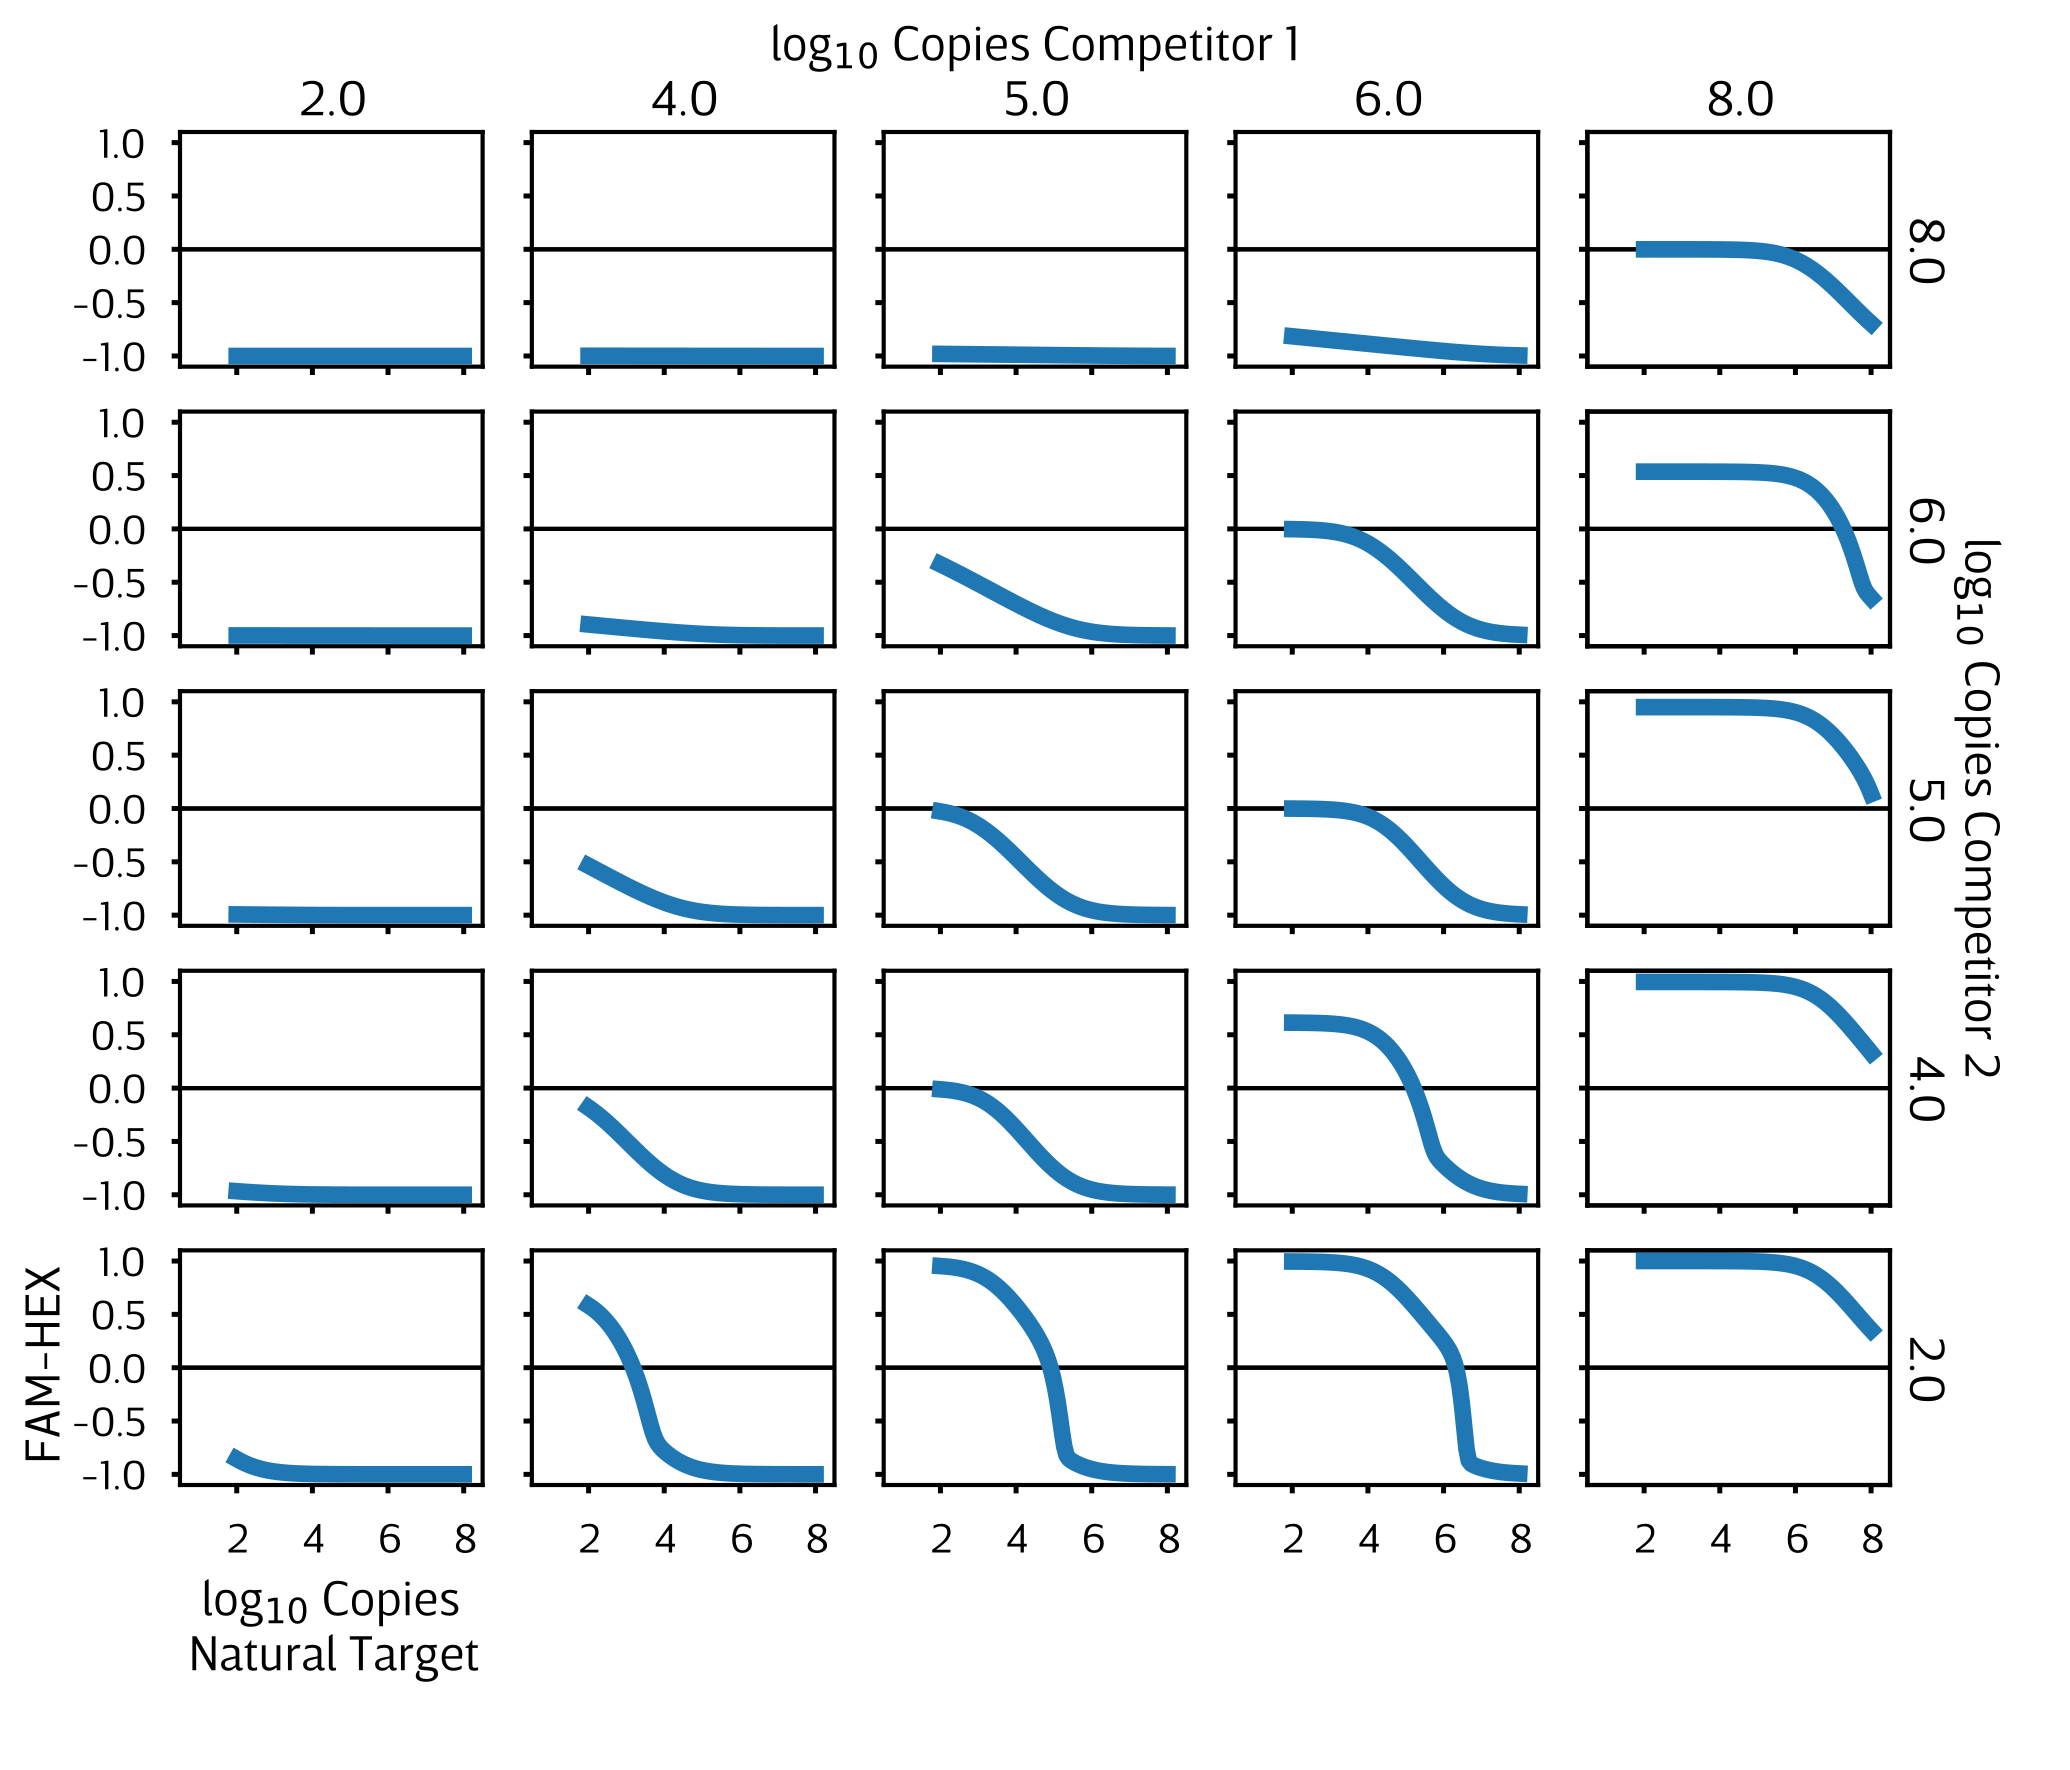

In [6]:
target = np.array([[-1, +1, 0, 0]])
competitor = np.array([[0, -1, +1, 0], [0, 0, -1, +1]])

positive_labels = np.array([[0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0]])

rxn_t = can.models.CAN(
    target,
    competitor,
    positive_labels,
    INT_names=["WT"],
    EXT_names=["REF1", "REF2"],
    label_names=["H", "F"],
)

rxn_t.n_cycles = 49
rxn_t.compile()


def sym_tripartite(
    ref1_rate,
    ref1_lgQ,
    ref2_rate,
    ref2_lgQ,
    wt_rate=0.9,
    wt_start=2,
    wt_end=8,
    n_points=100,
    ref1_drift=0,
    ref2_drift=0,
    wt_drift=0,
):

    rxn_t.oligo("WT").rate = wt_rate
    rxn_t.oligo("REF1").rate = ref1_rate
    rxn_t.oligo("REF2").rate = ref2_rate

    rxn_t.oligo("WT").drift = wt_drift
    rxn_t.oligo("REF1").drift = ref1_drift
    rxn_t.oligo("REF2").drift = ref2_drift

    rxn_t.oligo("REF1").copies = 10**ref1_lgQ
    rxn_t.oligo("REF2").copies = 10**ref2_lgQ

    wt_lgQ = np.linspace(wt_start, wt_end, n_points)

    arrays = [wt_lgQ]
    grids = jnp.meshgrid(*arrays)
    pts = jnp.vstack([grid.ravel() for grid in grids]).T

    rxn_t.sweep_setup = arrays, grids, pts, rxn_t.INT_idxs
    sol = rxn_t.solution_sweep()
    return wt_lgQ, sol


# wt_data = ps[ps.Target == "S036.5"]
# ref1_data = ps[ps.Target == "S057.3.2"]
# ref2_data = ps[ps.Target == "S057.4.2"]
wt_data = ps[ps.Target == "S036.0"]
ref1_data = ps[ps.Target == "S057.0.1"]
ref2_data = ps[ps.Target == "S057.1.2"]

ref1_rate=ref1_data["r"].mean()
ref2_rate=ref2_data["r"].mean()
wt_rate=wt_data["r"].mean()


print(f"{wt_rate=:.3f} | {ref1_rate=:.3f} | {ref2_rate=:.3f}")

fig, axs = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)
axes_dict = {
    (row, col): axs[i, j]
    for i, row in enumerate([2, 4, 5, 6, 8][::-1])
    for j, col in enumerate([2, 4, 5, 6, 8])
}

for (ref2_lgQ, ref1_lgQ), ax in axes_dict.items():
    wt_lgQ, sol = sym_tripartite(
        ref1_rate=ref1_rate,
        ref1_lgQ=ref1_lgQ,
        ref2_rate=ref2_rate,
        ref2_lgQ=ref2_lgQ,
        wt_rate=wt_rate,
    )
    ax.plot(wt_lgQ, sol)

    ax.axhline(0, color="k", linestyle="-", linewidth=0.5, zorder=-1)

format_sns_axes(fig, axs, axes_dict, xticks=[2, 4, 6, 8], xlim=[0.5, 8.5])
axs[-1, 0].set_xlabel(
    r"log$_{10}$ Copies" + "\nNatural Target", fontsize=labelsize, labelpad=2
)
axs[-1, 0].set_ylabel("FAM-HEX", fontsize=labelsize)

savefig(plt.gcf(), alias="stretchy_tetra")

wt_rate=0.822 | ref1_rate=0.519 | ref2_rate=0.497
Saving fig_S9B__floral_wildebeest in /home/john/projects/can-manuscript/fig_S9__soft_lamprey/graphics: [.svg] [.png] done


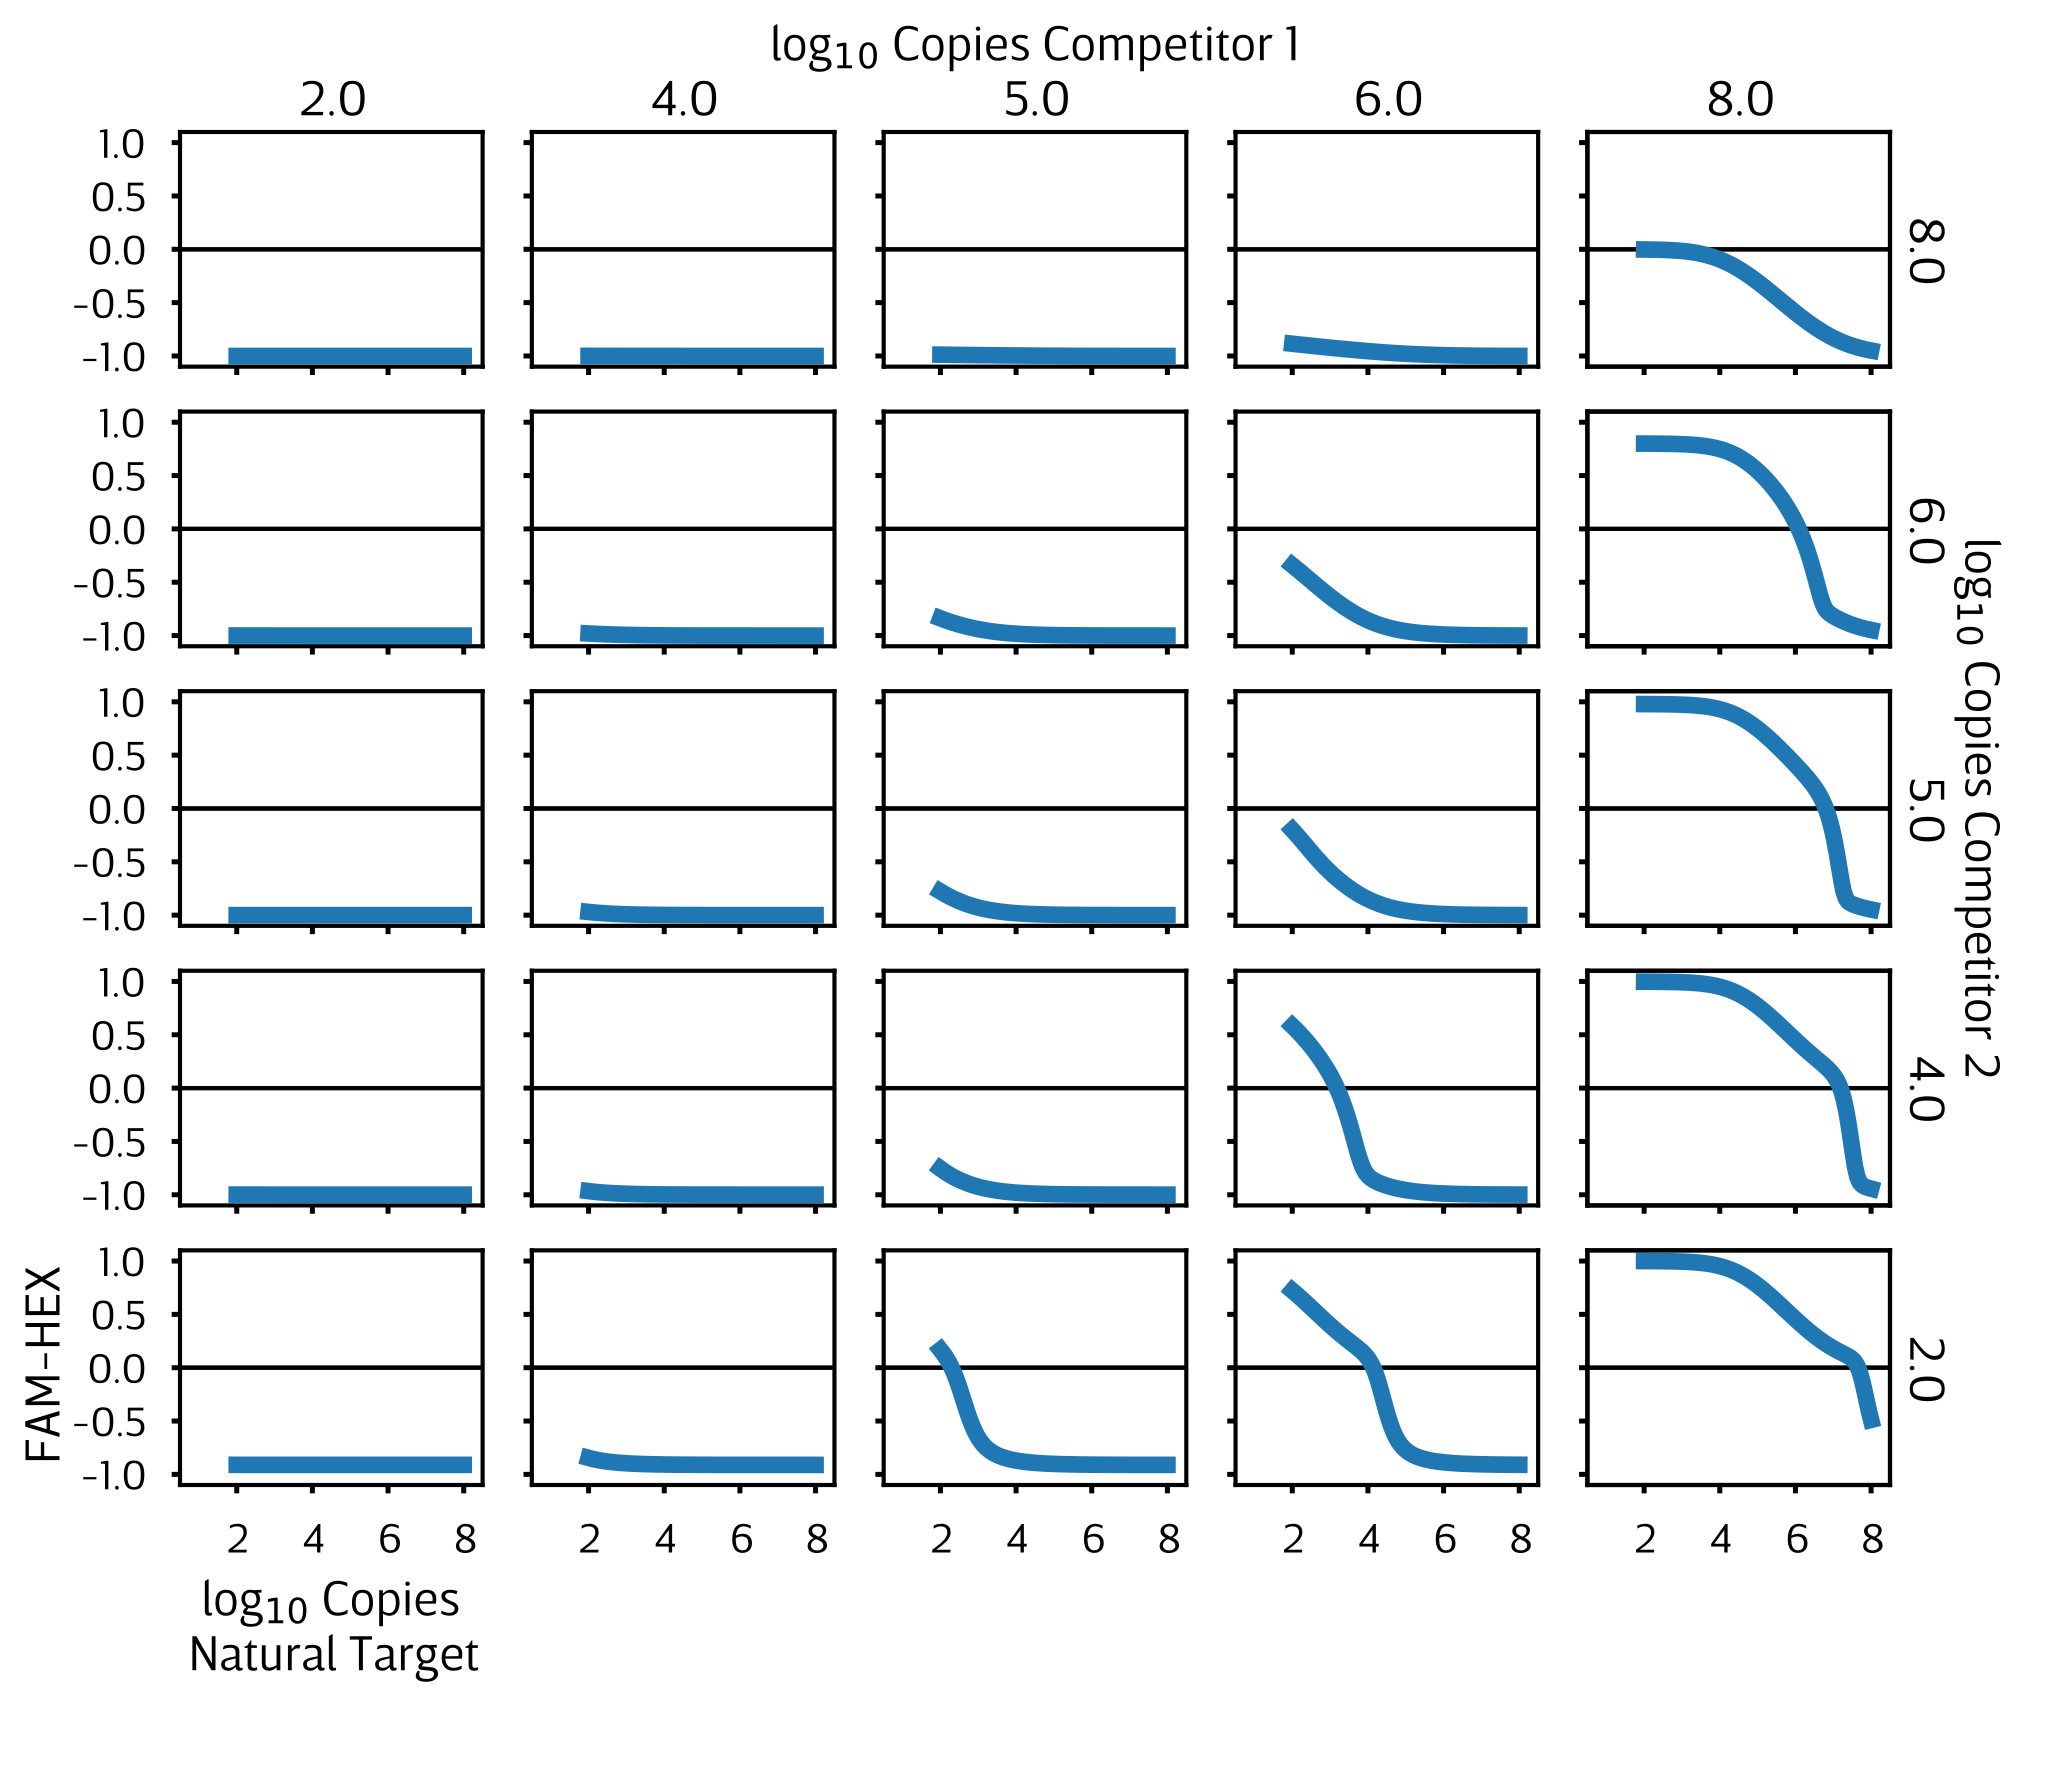

In [7]:

wt_data = ps[ps.Target == "S036.5"]
ref1_data = ps[ps.Target == "S057.3.2"]
ref2_data = ps[ps.Target == "S057.4.2"]
# wt_data = ps[ps.Target == "S036.0"]
# ref1_data = ps[ps.Target == "S057.0.1"]
# ref2_data = ps[ps.Target == "S057.1.2"]

ref1_rate=ref1_data["r"].mean()
ref2_rate=ref2_data["r"].mean()
wt_rate=wt_data["r"].mean()

print(f"{wt_rate=:.3f} | {ref1_rate=:.3f} | {ref2_rate=:.3f}")

fig, axs = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)
axes_dict = {
    (row, col): axs[i, j]
    for i, row in enumerate([2, 4, 5, 6, 8][::-1])
    for j, col in enumerate([2, 4, 5, 6, 8])
}

for (ref2_lgQ, ref1_lgQ), ax in axes_dict.items():
        wt_lgQ, sol = sym_tripartite(
            ref1_rate=ref1_rate,
            ref1_lgQ=ref1_lgQ,
            ref2_rate=ref2_rate,
            ref2_lgQ=ref2_lgQ,
            wt_rate=wt_rate,
        )
        ax.plot(wt_lgQ, sol)
        
        ax.axhline(0, color="k", linestyle="-", linewidth=0.5, zorder=-1)

format_sns_axes(fig, axs, axes_dict, xticks=[2, 4, 6, 8], xlim=[0.5, 8.5])
axs[-1, 0].set_xlabel(r"log$_{10}$ Copies"+"\nNatural Target", fontsize=labelsize, labelpad=2)
axs[-1, 0].set_ylabel("FAM-HEX", fontsize=labelsize)

savefig(plt.gcf(), alias="floral_wildebeest")